# Feature Adversaries Attack in PyTorch

Before diving into the attack, let's first prepare a classification model. We utilize a script from the `examples` folders.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import FeatureAdversariesPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = nn.Sequential(
    nn.Conv2d(1, 4, 5), nn.ReLU(), nn.MaxPool2d(2, 2), 
    nn.Conv2d(4, 10, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Flatten(), 
    nn.Linear(4*4*10, 100),    
    nn.Linear(100, 10)
)
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 96.61999999999999%


---

## PGD variant of Feature Adversaries


In [2]:
# Step 5: prepare a batch of source and guide images
valid = np.argmax(y_test, axis=1)[:100] != np.argmax(y_test, axis=1)[100:200]
source = x_test[:100][valid][:32]
guide = x_test[100:200][valid][:32]

In [3]:
# Step 6: Generate adversarial test examples
attack = FeatureAdversariesPyTorch(
    classifier,
    layer=7,
    delta=35/255,
    optimizer=None,
    step_size=1/255,
    max_iter=100,
)
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

dim = tuple(range(1, len(source.shape)))
pert = np.mean(np.amax(np.abs(source - x_test_adv), axis=dim))
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Feature Adversaries PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test batch: 3.125%
Average perturbation: 0.13725492358207703%


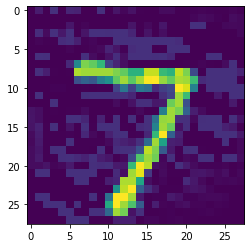

In [4]:
# Step 8: Inspect results

# orig 7, guide 6
plt.imshow(x_test_adv[0,...].squeeze())

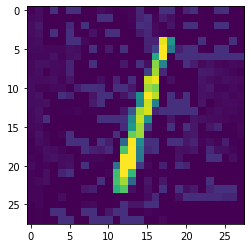

In [5]:
# orig 1, guide 5
plt.imshow(x_test_adv[2,...].squeeze())

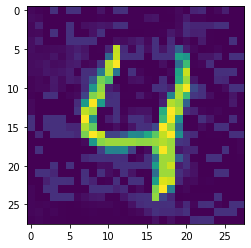

In [6]:
# orig 4, guide 9
plt.imshow(x_test_adv[4,...].squeeze())

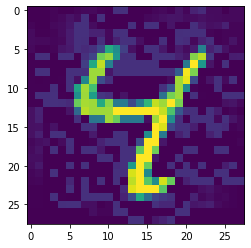

In [7]:
# orig 4, guide 2
plt.imshow(x_test_adv[6,...].squeeze())

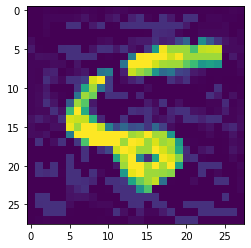

In [8]:
# orig 5, guide 9
plt.imshow(x_test_adv[8,...].squeeze())

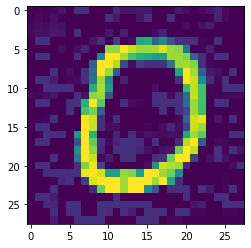

In [9]:
# orig 0, guide 8
plt.imshow(x_test_adv[10,...].squeeze())


## Unconstrained variant of Feature Adversaries

This variant approximates the original hard constraint problem of the paper. Any available PyTorch optimizer can be used. We will use Adam as a good default one.


In [10]:
# Step 6: Generate adversarial test examples
attack = FeatureAdversariesPyTorch(
    classifier,
    layer=7,
    delta=61/255,
    optimizer=optim.Adam,
    optimizer_kwargs={"lr": 0.01},
    lambda_=1.0,
    max_iter=100,
    random_start=True
)
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

dim = tuple(range(1, len(source.shape)))
pert = np.mean(np.amax(np.abs(source - x_test_adv), axis=dim))
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Feature Adversaries PyTorch:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test batch: 0.0%
Average perturbation: 0.2517760694026947%


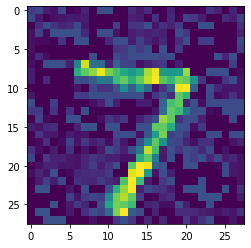

In [11]:
# Step 8: Inspect results

# orig 7, guide 6
plt.imshow(x_test_adv[0,...].squeeze())

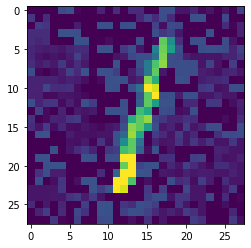

In [12]:
# orig 1, guide 5
plt.imshow(x_test_adv[2,...].squeeze())

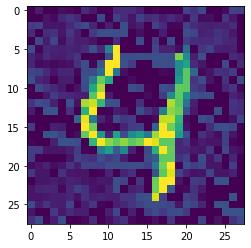

In [13]:
# orig 4, guide 9
plt.imshow(x_test_adv[4,...].squeeze())

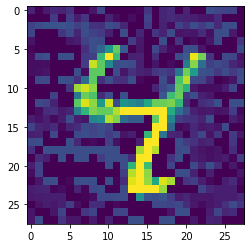

In [14]:
# orig 4, guide 2
plt.imshow(x_test_adv[6,...].squeeze())

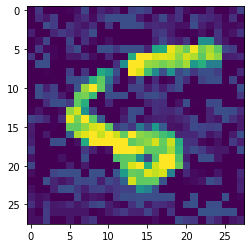

In [15]:
# orig 5, guide 9
plt.imshow(x_test_adv[8,...].squeeze())

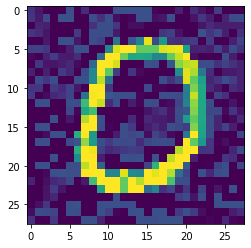

In [16]:
# orig 0, guide 8
plt.imshow(x_test_adv[10,...].squeeze())